# Extraer Histogramas de eventos unicos (randon vtx, random dir)

In [4]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sn

In [16]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    #Atencion! Esta funcion necesita al menos dos vectores para devolver su modulo pues esta diseñada para leer componentes de array. Si le es pasado un unico vertor ir a devolver los escalares de entrada ...
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [5]:
file = uproot.open("/snoplus simulations/electron bulk/random point/random dir/High Statistic/simu_Analysis_elec_5MeV.root")
file.keys()

['T;61', 'T;60', 'pmt;2', 'pmt;1']

In [6]:
data1 = file['T;61']
pmt_info = file['pmt;1']

## 1.1 - EV info

In [24]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
mc_position = np.array(data1['mc_position'])   #-> Position Generation
mc_momentum = np.array(data1['mc_momentum'])   #-> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## - ! Obtain radius of the event

## 1.2 - PMT info

In [25]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

## 1.3 - Extract Valid PMT info index

- Index

In [26]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([        0,         1,         2, ..., 131016005, 131016006,
       131016007], dtype=int64)

- PMT valid ID

In [27]:
condition = (pmt_type == 1)
pmt_valid_id = np.extract(condition, pmt_id)
pmt_valid_id

array([   1,    2,    3, ..., 9693, 9694, 9695], dtype=int16)

## 1.3 - Encontrar Segmentación de eventos

In [28]:
#Separar mcIDs:
break_i = [0] #List of indices where data change of event ID
N_data = len(mcID)
for i in range(N_data-1):
    if mcID[i] != mcID[i+1]:
        break_i.append(i+1)
break_i = np.array(break_i, dtype = np.int32)

In [29]:
break_i

array([        0,      1449,      2884, ..., 131012012, 131013478,
       131015032])

In [31]:
mc_position[0:2]

array([[ 3464.75854492, -1662.61291504,  1521.85205078],
       [ 3464.75854492, -1662.61291504,  1521.85205078]])

## 1.4 - Extraer información valida de un evento

In [37]:
#Choose an evID
ev_id = 0

ev_i = break_i[ev_id]
ev_f = break_i[ev_id + 1]

#Observable
#time residual:
time_res_ev = time_residual[ev_i:ev_f]

#MC radius
mc_position_ev = mc_position[ev_i:ev_f][0]
mc_radius_ev = np.linalg.norm(mc_position_ev)

#extract valid observable data (PMT Type = 1)
pmt_id_ev = hit_pmtid[ev_i:ev_f]

valid_info_i = np.where(np.in1d(pmt_id_ev, pmt_valid_id))[0]

#filtered observable
time_res_ev = time_res_ev[valid_info_i]

In [38]:
time_res_ev

array([-45.65518609,   5.42532689,  -0.39643325, ..., 202.19019088,
       209.54229756, 232.62140695])

In [39]:
mc_radius_ev

4133.3844660678415

# 2 - Graficar los Observables

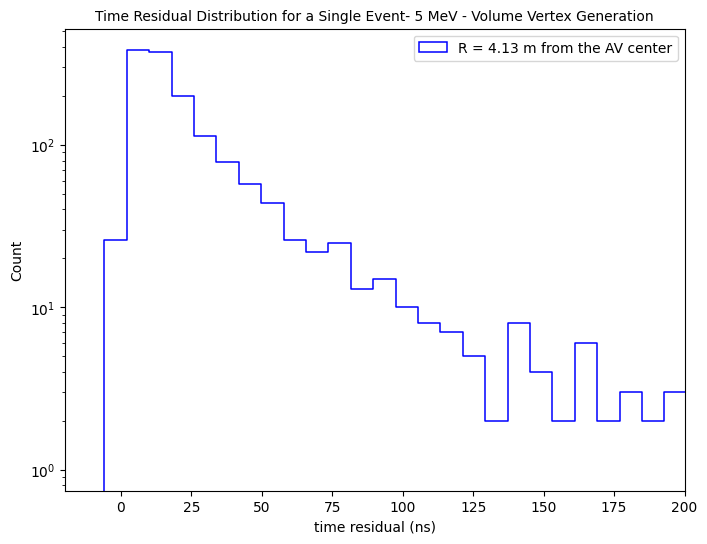

In [51]:
sn.reset_orig()
# Crear el histograma utilizando seaborn

plt.figure(figsize=(8,6))

sn.histplot(time_res_ev, binwidth = 8, element = 'step', alpha = 0, color = 'blue', linewidth = 1.1, label = 'R = '+str('{:.2f}'.format(mc_radius_ev/1000)) + ' m from the AV center')

plt.title(r'Time Residual Distribution for a Single Event- 5 MeV - Volume Vertex Generation', fontsize = 10)
plt.legend(loc = 'best')
plt.xlabel('time residual (ns)')

plt.xlim(-20, 200)
plt.yscale('log')
plt.savefig('figs/time residual single event - 5 MeV - volume vtx.png', format = 'png', bbox_inches = 'tight')
plt.show()